In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import time
from IPython import display
from tqdm import tqdm_notebook

TensorFlow 2.x selected.


## Pix 2 Pix is a kind of gan that the model get pixcel image and output the realistic image

In [6]:
# Get Data
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

data_path = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)

30171136/30168306 [==============================] - 0s 0us/step


In [7]:
os.listdir('/root/.keras/datasets/facades')


['test', 'val', 'train']

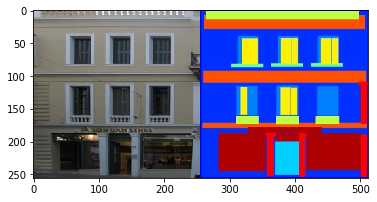

In [8]:
# check first train data

first_image_path = os.path.join('/root/.keras/datasets/facades/train/', os.listdir('/root/.keras/datasets/facades/train')[0])
first_image = os.path.join('/root/.keras/datasets/facades/train/', os.listdir('/root/.keras/datasets/facades/train')[0])
first_image = plt.imread(first_image)
plt.imshow(first_image)

In [0]:
class hp:
  width = 256
  height = 256
  channel = 3
  batch = 1
  buffer = 400
  LAMBDA = 100
  EPOCHS = 150

hp = hp()

In [0]:
def load_data(path):
  '''
  input : 
      path
  processing :
      half of the image is real and other is pix image
      cast to float
  return : 
      input_image & real_image
  '''
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  w = tf.shape(img)[1]  # !! should put tf.shape(img), NOT just img.shape

  w = w // 2
  real_image = img[:, :w, :]
  pix_image = img[:, w:, :]

  real_image = tf.cast(real_image, tf.float32)
  pix_image = tf.cast(pix_image, tf.float32)
  return pix_image, real_image

In [0]:
def resize(pix_image, real_image):
  pix_image = tf.image.resize(pix_image,
                              size = (hp.height, hp.width),
                              method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  real_image = tf.image.resize(real_image,
                               size = (hp.height, hp.width),
                               method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return pix_image, real_image

In [0]:
def random_crop(pix_image, real_image):
  '''
  if the image is bigger than the random_crop, 
  the output image is fixed by the image size
  '''
  stacked_image = tf.stack([pix_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size = [2, hp.height, hp.width, 3]) 
  return cropped_image[0], cropped_image[1]

In [0]:
def normalize(pix_image, real_image):
  '''
  pixcel values should be [-1, 1]
  so convert to [0, 255] to [-1, 1]
  '''
  pix_image = (pix_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return pix_image, real_image

In [14]:
tf.random.uniform(()).numpy()

0.71432555

In [0]:
# Training augmentation
def random_jitter(pix_image, real_image):
  '''
  tf.random.uniform(()).numpy()
    output = [0, 1) value
  '''
  pix_image, real_image = resize(pix_image, real_image)
  pix_image, real_image = random_crop(pix_image, real_image)

  if tf.random.uniform(()) > 0.5:
    pix_image = tf.image.random_flip_left_right(pix_image)
    real_image = tf.image.random_flip_left_right(real_image)  

  pix_image, real_image = normalize(pix_image, real_image)
  return pix_image, real_image

In [16]:
first_image_path

'/root/.keras/datasets/facades/train/240.jpg'

In [0]:
# Define train data loader
train_data = tf.data.Dataset.list_files('/root/.keras/datasets/facades/' + 'train/*.jpg')
train_data = train_data.map(load_data)
train_data = train_data.map(random_jitter)
train_data = train_data.shuffle(hp.buffer)
train_data = train_data.batch(hp.batch)
train_data = train_data.prefetch(2)

# Define test data loader
test_data = tf.data.Dataset.list_files('/root/.keras/datasets/facades/' + 'val/*.jpg')
test_data = test_data.map(load_data)
test_data = test_data.map(normalize)
test_data = test_data.batch(hp.batch)
test_data = test_data.prefetch(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


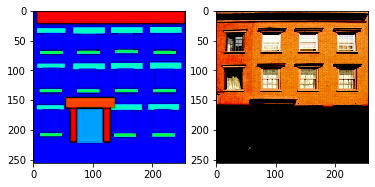

In [18]:
a, b = next(iter(train_data))

plt.subplot(1, 2, 1)
plt.imshow(a[0])
plt.subplot(1,2, 2)
plt.imshow(b[0])

In [0]:
# Define blocks
def downsample_fun(filters, kernel_size, apply_batchnorm=True):
  init = tf.keras.initializers.RandomNormal(0., 0.02)
  x = tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same', kernel_initializer=init, use_bias=False)
  if apply_batchnorm:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)
  return x

# Class api
class downsample(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, apply_batchnorm=True):
    super(downsample, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.apply_batchnorm = apply_batchnorm

    self.init = tf.keras.initializers.RandomNormal(0., 0.02)
    self.conv = tf.keras.layers.Conv2D(self.filters, self.kernel_size, strides=2, padding='same', kernel_initializer=self.init, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization()
    self.at = tf.keras.layers.LeakyReLU()
  
  def call(self, x):
    x = self.conv(x)
    if self.apply_batchnorm:
      x = self.bn(x)
    x = self.at(x)
    return x


def upsample_fun(filters, kernel_size, apply_dropout=True):
  init = tf.keras.initializers.RandomNormal(0., 0.02)
  x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=init, use_bias=False)
  x = tf.keras.layers.BatchNormalization()(x)

  if apply_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)
  return x  


class upsample(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, apply_dropout=True):
    super(upsample, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.apply_dropout = apply_dropout

    self.init = tf.keras.initializers.RandomNormal(0., 0.02)
    self.convt = tf.keras.layers.Conv2DTranspose(self.filters, self.kernel_size, strides=2, padding='same', kernel_initializer=self.init, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization()
    self.do = tf.keras.layers.Dropout(0.5)
    self.at = tf.keras.layers.ReLU()
  
  def call(self, x):
    x = self.convt(x)
    x = self.bn(x)
    if self.apply_dropout:
      x = self.do(x)
    x = self.at(x)
    return x


# Define Generator
def Generator():
  '''
  Modify U-net
  '''
  init = tf.keras.initializers.RandomNormal(0., 0.02)

  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [downsample(64, 4, apply_batchnorm=False),
                downsample(128,4),
                downsample( 256,4),
                downsample( 512,4),
                downsample( 512,4),
                downsample( 512,4),
                downsample( 512,4),
                downsample( 512,4)]
  
  up_stack = [upsample( 512, 4, apply_dropout=True), # 1024
              upsample( 512, 4, apply_dropout=True), # 1024
              upsample( 512, 4, apply_dropout=True), # 1024
              upsample( 512, 4),                     # 1024
              upsample( 256, 4),                     # 512
              upsample( 128, 4),                     # 256
              upsample( 64, 4)                       # 128
              ]
  
  x = inputs
  skip = []
  for down in down_stack:
    x = down(x)
    skip.append(x)
  
  skip = reversed(skip[:-1])

  for up, skip in zip(up_stack, skip):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  
  x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, use_bias=False)(x)

  return tf.keras.models.Model(inputs, x)


In [0]:
# Define Discriminator

class Discriminator(tf.keras.Model):
  def __init__(self, ):
    super(Discriminator, self).__init__()
    self.inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    self.tag = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    self.concat = tf.keras.layers.Concatenate()
    self.d1 = downsample(64, 4, False)
    self.d1 = downsample(128, 4)
    self.d2 = downsample(256, 4)

    self.conv = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(0., 0.02), use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization()
    self.zeropad= tf.keras.layers.ZeroPadding2D()
    self.ac = tf.keras.layers.LeakyReLU()
    self.out = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=tf.keras.initializers.RandomNormal(0., 0.02))

  def call(self, inputs):
    # [self.inp, self.tag] = x 
    self.inp, self.tag = inputs
    x = self.concat()([self.inp, self.tag])
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.conv(x)
    x = self.bn(x)
    x = self.ac(x)
    return self.out(x)



In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256,256,3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')

  x = tf.keras.layers.Concatenate()([inp, tar]) 

  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # padding (1,1)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model([inp, tar], last)

In [0]:
generator = Generator()

In [0]:
discriminator = Discriminator()

In [0]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
@tf.function
def generator_loss(disc_output, gen_output, target):
  '''
  total gan loss :
    compare : discriminator output = 1
              discriminator real out = predicted
  '''
  gan_loss = loss_function(tf.ones_like(disc_output), disc_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_generator_loss = gan_loss + (hp.LAMBDA * l1_loss)
  
  return gan_loss, l1_loss, total_generator_loss

In [0]:
@tf.function
def discriminator_loss(disc_output, gen_output):
  '''
  for discriminator, 
    disc_output = all 1
    generator output = all 0
  '''
  real_loss = loss_function(tf.ones_like(disc_output), disc_output)
  fake_loss = loss_function(tf.zeros_like(gen_output), gen_output)
  disc_loss = real_loss + fake_loss
  return disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [0]:
# set check point

check_point_dir = 'training_checkpoint'
checkpoint_prefix = os.path.join(check_point_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


In [0]:
def generate_image(model, test_input, target):
  prediction = model(test_input, training=True)   # Even the result is prediction, the model archtecture designed to get input the pix image
   
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], target[0], prediction[0]] # [-1, 1] requires to de-normalize  y = (x / 127.5) -1
  display_title = ['Pix Image', 'Target Image', 'GAN Generated']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(display_title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


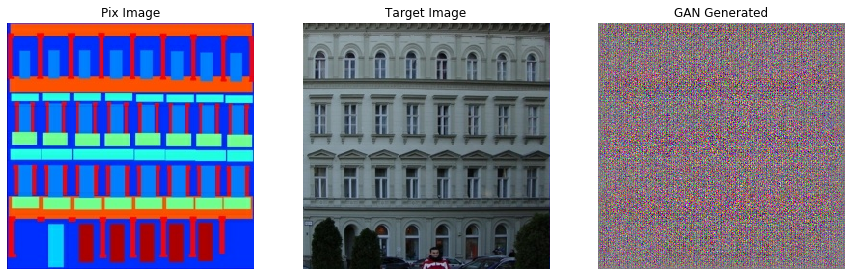

In [31]:
for example_input, example_target in test_data.take(1):
  generate_image(generator, example_input, example_target)

In [0]:
log_dir = 'logs/'

sumamry_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [33]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Output hidden; open in https://colab.research.google.com to view.

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    # gan_loss, l1_loss, total_generator_loss = generator_loss(target, gen_output, )

    disc_real_out = discriminator([input_image, target], training=True)
    disc_fake_out = discriminator([input_image, gen_output], training=True)

    gan_loss, l1_loss, total_generator_loss  = generator_loss(disc_fake_out, gen_output, target )
    disc_loss = discriminator_loss(disc_real_out, disc_fake_out)

  generator_g = gen_tape.gradient(total_generator_loss, generator.trainable_variables)
  discriminator_g = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_g, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_g, disciminator.trainable_variables))  # DONT FORGET TO ZIP THE GRADIENT AND TRAINABLE VARIABLES

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', total_generator_loss, step=epoch)
    tf.summary.scalar('total_GAN_loss', gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', l1_loss, step=epoch)
    tf.summary.scalar('Discriminator_loss', disc_loss, step=epoch)

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gan_loss, l1_loss, gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradient = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

  p_format = 'Epoch : {}\tGan Loss : {}\tDiscriminator Loss : {}\tGenerator Loss : {}'
  p_format.format(epoch, gan_loss, disc_loss, gen_total_loss)

  with sumamry_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_data, test_data, epochs):
  for epoch in tqdm_notebook(range(epochs)):
    start = time.time()
    display.clear_output(wait=True)

    for example_input, example_target in test_data.take(1):
      generate_image(generator, example_input, example_target)
    print('Epoch : {}'.format(epoch+1))

    for n, (input_image, target_image) in tqdm_notebook(enumerate(train_data)):
      # print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target_image, epoch)
    print()

    if (epoch+1) % 10 == 0:
      checkpoint.save(checkpoint_prefix)
    
    print('Time take for epoch{} -- {}'.format(epoch+1, time.time() - start))

  checkpoint.save(checkpoint_prefix)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


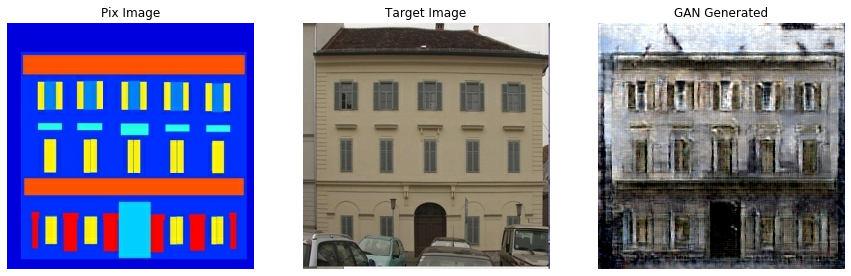

Epoch : 150







Time take for epoch150 -- 25.670315980911255



In [37]:
# Fit the model
fit(train_data, test_data, hp.EPOCHS)

In [39]:
tensorboard dev upload --logdir  'logs/'  # tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/tensorflow-2.1.0/python3.6/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/tensorflow-2.1.0/python3.6/tensorboard/main.py", line 66, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/tensorflow-2.1.0/python3.6/absl/app.py", line 299, in run
 

In [40]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [47]:
check_point_dir

'training_checkpoint'

In [108]:
tf.train.latest_checkpoint(check_point_dir)

'training_checkpoint/ckpt-16'

In [0]:
'training_checkpoint/ckpt-10'

In [109]:
generator = Generator()
discriminator = Discriminator()
checkpoint.restore('training_checkpoint/ckpt-10')

In [0]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


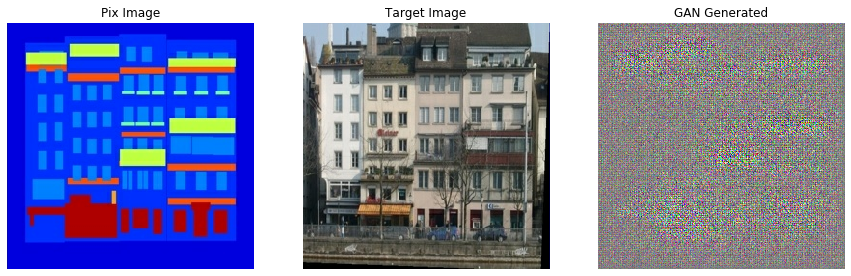

Epoch : 1







Time take for epoch1 -- 21.712754011154175



In [114]:
# Fit the model
fit(train_data, test_data, 1)

In [110]:
checkpoint

In [91]:
!ls {check_point_dir}

checkpoint		     ckpt-2.data-00000-of-00002
ckpt-10.data-00000-of-00002  ckpt-2.data-00001-of-00002
ckpt-10.data-00001-of-00002  ckpt-2.index
ckpt-10.index		     ckpt-3.data-00000-of-00002
ckpt-11.data-00000-of-00002  ckpt-3.data-00001-of-00002
ckpt-11.data-00001-of-00002  ckpt-3.index
ckpt-11.index		     ckpt-4.data-00000-of-00002
ckpt-12.data-00000-of-00002  ckpt-4.data-00001-of-00002
ckpt-12.data-00001-of-00002  ckpt-4.index
ckpt-12.index		     ckpt-5.data-00000-of-00002
ckpt-13.data-00000-of-00002  ckpt-5.data-00001-of-00002
ckpt-13.data-00001-of-00002  ckpt-5.index
ckpt-13.index		     ckpt-6.data-00000-of-00002
ckpt-14.data-00000-of-00002  ckpt-6.data-00001-of-00002
ckpt-14.data-00001-of-00002  ckpt-6.index
ckpt-14.index		     ckpt-7.data-00000-of-00002
ckpt-15.data-00000-of-00002  ckpt-7.data-00001-of-00002
ckpt-15.data-00001-of-00002  ckpt-7.index
ckpt-15.index		     ckpt-8.data-00000-of-00002
ckpt-16.data-00000-of-00002  ckpt-8.data-00001-of-00002
ckpt-16.data-00001-of-00002  c

In [0]:
test = checkpoint.restore(tf.train.latest_checkpoint(check_point_dir))

In [94]:
test

In [72]:
test_model

In [59]:
! training_checkpoint

logs  sample_data  training_checkpoint


In [107]:
for inp, tar in test_data.take(5):
  generate_image(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
gen = checkpoint.restore(tf.train.latest_checkpoint('/content/training_checkpoint'))

In [98]:
gen.

In [0]:
# Generator

tf.keras.utils.plot_model(gen, show_shapes=True, dpi=64)

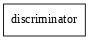

In [0]:
# Discirminator

tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64, expand_nested=True)

In [0]:
np.mean(a.numpy())

119.45804

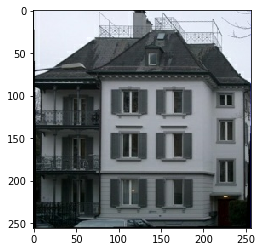

In [0]:
a, b = load_data(first_image_path)
plt.imshow(b/255.) 

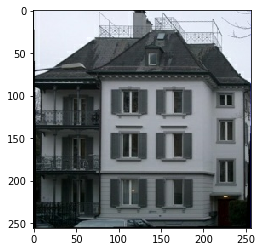

In [0]:
a, b = random_crop(a, b)
plt.imshow(b/255.)